In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import sinter
import stim
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.stability import StabilityPatch
from stim_surface_code import noise

In [2]:
m = MemoryPatch(5, 5, 5)
m

--------------------------------------------------------
|    |    |Z 25|    |    |    |Z 26|    |    |    |    |
----------+----+--------------+----+--------------------
|    |   0|    |   1|    |L  2|    |   3|    |   4|    |
----------+----+----+----+----+----+----+----+----+-----
|    |    |X 27|    |Z 28|    |X 29|    |Z 30|    |X 31|
----------+----+----+----+----+----+----+----+----+-----
|    |   5|    |   6|    |L  7|    |   8|    |   9|    |
-----+----+----+----+----+----+----+----+----+----------
|X 32|    |Z 33|    |X 34|    |Z 35|    |X 36|    |    |
-----+----+----+----+----+----+----+----+----+----------
|    |  10|    |  11|    |L 12|    |  13|    |  14|    |
----------+----+----+----+----+----+----+----+----+-----
|    |    |X 37|    |Z 38|    |X 39|    |Z 40|    |X 41|
----------+----+----+----+----+----+----+----+----+-----
|    |  15|    |  16|    |L 17|    |  18|    |  19|    |
-----+----+----+----+----+----+----+----+----+----------
|X 42|    |Z 43|    |X 44|    |

In [3]:
# 10x better noise vals than Google's device
noise_params = noise.GoogleNoiseParams.improve(10)
noise_params.error_stdevs = {k: 0 for k in noise_params.error_stdevs}
print(noise_params.error_means)

{'T1': 0.0002, 'T2': 0.00030000000000000003, 'gate1_err': 9.015368548802825e-07, 'gate2_err': 0.00035424042547487725, 'readout_err': 0.0002}


In [4]:
noise_params.set_patch_err_vals(m)

In [5]:
# We can use Sinter for a single task...
m.count_logical_errors(use_sinter=True)

(0.0003086, 10000000)

In [6]:
# ...or we can use Sinter for a batch of tasks
mem_tasks = []
ps = np.geomspace(1e-3,3/4,10)
ds = [3,5,7,9]
for d in ds:
    m = MemoryPatch(d, d, d)
    for p in ps:
        noise_params = noise.NoiseParams(
            baseline_error_means = {
                'T1': np.inf,
                'T2': np.inf,
                'gate1_err': p,
                'gate2_err': p,
                'readout_err': p,
            }
        )
        noise_params.set_patch_err_vals(m)
        mem_tasks.append(m.get_sinter_task(
            task_kwargs={
                'json_metadata': {'d': d, 'p': p},
                'decoder': 'pymatching',
            },
            observable_basis='Z'
        ))

In [7]:
mem_collected_stats = sinter.collect(tasks=mem_tasks, num_workers=6, max_shots=10**6, max_errors=500)

In [8]:
# compare to Stim's built-in surface code
default_tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d,
            distance=d,
            after_clifford_depolarization=p,
            before_measure_flip_probability=p,
        ),
        json_metadata={'d': d, 'p': p},
    )
    for d in ds
    for p in ps
]

default_stats: list[sinter.TaskStats] = sinter.collect(
    num_workers=6,
    tasks=default_tasks,
    decoders=['pymatching'],
    max_shots=10**6,
    max_errors=500,
)

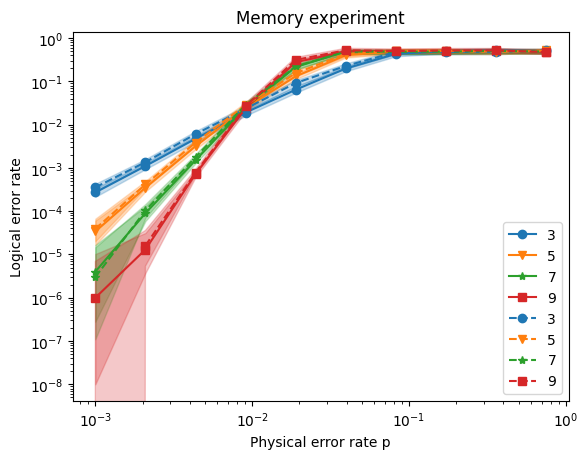

In [9]:
fig,ax = plt.subplots()
sinter.plot_error_rate(ax=ax, stats=mem_collected_stats, x_func=lambda stats: stats.json_metadata['p'], group_func=lambda stats: stats.json_metadata['d'])
sinter.plot_error_rate(ax=ax, stats=default_stats, x_func=lambda stats: stats.json_metadata['p'], group_func=lambda stats: stats.json_metadata['d'], plot_args_func=lambda a,b,c: {'linestyle': '--'})
ax.legend()
ax.loglog()
plt.title('Memory experiment')
plt.xlabel('Physical error rate p')
plt.ylabel('Logical error rate')
plt.show()

In [12]:
# stability
stab_tasks = []
ps = np.geomspace(1e-3,3/4,10)
ds = [4,6,8,10]
for d in ds:
    s = StabilityPatch(d, d, d)
    for p in ps:
        noise_params = noise.NoiseParams(
            baseline_error_means = {
                'T1': np.inf,
                'T2': np.inf,
                'gate1_err': p,
                'gate2_err': p,
                'readout_err': p,
            }
        )
        noise_params.set_patch_err_vals(s)
        stab_tasks.append(s.get_sinter_task(
            task_kwargs={
                'json_metadata': {'d': d, 'p': p},
                'decoder': 'pymatching',
            }
        ))

In [11]:
stab_collected_stats = sinter.collect(tasks=stab_tasks, num_workers=6, max_shots=10**6, max_errors=500)

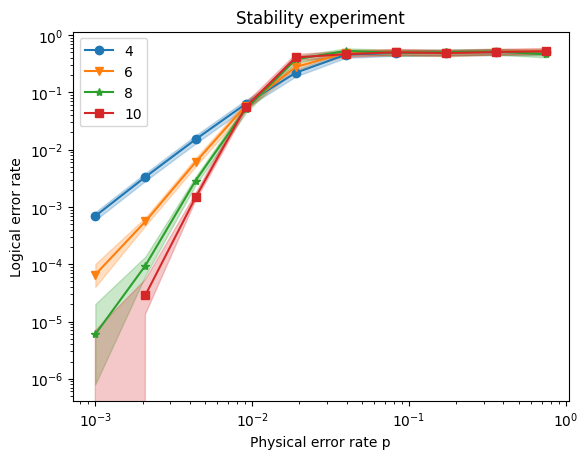

In [16]:
fig,ax = plt.subplots()
sinter.plot_error_rate(ax=ax, stats=stab_collected_stats, x_func=lambda stats: stats.json_metadata['p'], group_func=lambda stats: stats.json_metadata['d'])
ax.legend()
ax.loglog()
plt.title('Stability experiment')
plt.xlabel('Physical error rate p')
plt.ylabel('Logical error rate')
plt.show()